# Цветовые схемы. Преобразования цветовых схем.

In [1]:
#import matplotlib
#matplotlib.use('qt5agg')
#%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np

import random
import pathlib

from matplotlib.colors import LinearSegmentedColormap

 *Преобразования в разные цветовые схемы: RGB, CMYK, HSV, CIE YCbCr*

\begin{equation}
e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i
\end{equation}

_**Inline formula:**_ $e^{i\pi} + 1 = 0$

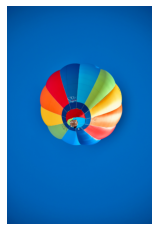

In [2]:
path = "img/medium"
collection = images = [p for p in pathlib.Path(path).iterdir() if p.suffix in [".jpg", ".jpeg"]]
img = plt.imread(random.choice(collection))

#figure, axes = plt.subplots()
plt.imshow(img, cmap='hsv')
plt.axis('off')
plt.show()

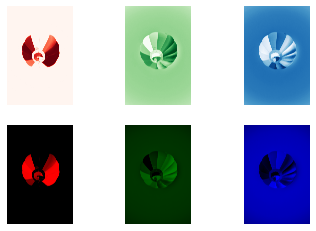

In [3]:
colormaps = [
    ["Reds", "Greens", "Blues"],
    [
        LinearSegmentedColormap.from_list("BkR", ["Black", "Red"]),
        LinearSegmentedColormap.from_list("BkG", ["Black", "Green"]),
        LinearSegmentedColormap.from_list("BkBu", ["Black", "Blue"])
    ],
]

for cm in range(len(colormaps)):
    for ch in range(len(colormaps[cm])):
        plt.subplot(2, 3, cm*3 + ch+1).imshow(img[:, :, ch], cmap=colormaps[cm][ch])

for axes in plt.gcf().findobj(plt.Axes):
    axes.set_axis_off()
plt.show()

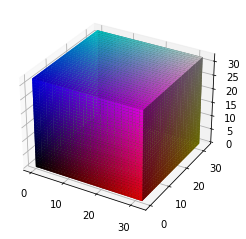

In [4]:
# RGB cube
granularity = 8
edge_len= int(256 / granularity)
space = np.indices((edge_len, edge_len, edge_len))
cube = (space[0] < edge_len) & (space[1] < edge_len) & (space[2] < edge_len)

colors = np.transpose(space, (1, 2, 3, 0)) / edge_len
plt.figure().add_subplot(projection='3d').voxels(cube, facecolors=colors, linewidth=0.5)
plt.show()

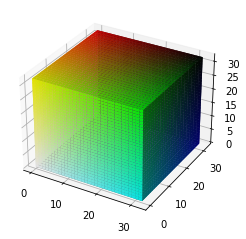

In [5]:
#CMY cube
plt.figure().add_subplot(projection='3d').voxels(cube, facecolors=(1 - colors), linewidth=0.5)
plt.show()

In [6]:
import scipy.spatial.transform.rotation
cube_rotation = scipy.spatial.transform.Rotation.from_euler("XYZ", (45, 45, 45), degrees=True)
hsv_space = cube_rotation.apply(space)

plt.figure().add_subplot(projection='3d')\
    .voxels(hsv_space[0], hsv_space[1], hsv_space[2], facecolors=colors, linewidth=0.5)
plt.show()

ValueError: Expected input of shape (3,) or (P, 3), got (3, 32, 32, 32).